In [309]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.preprocessing import RobustScaler
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix

In [82]:
df = pd.read_json("logins.json")

In [83]:
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [185]:
df['year'] = pd.DatetimeIndex(df['login_time']).year
df['month'] = pd.DatetimeIndex(df['login_time']).month
df['day'] = pd.DatetimeIndex(df['login_time']).day
df['hour'] = pd.DatetimeIndex(df['login_time']).hour
df['minute_actual'] = pd.DatetimeIndex(df['login_time']).minute
df['dow'] = pd.DatetimeIndex(df['login_time']).dayofweek


In [85]:
df['minutes'] = 15*df['minute_actual'].apply(lambda x: int(x/15))

In [155]:
df['new_date'] = pd.to_datetime(df[['year','month','day','hour','minutes']])
df['new_date_hour'] = pd.to_datetime(df[['year','month','day','hour']])

In [156]:
df.tail(10)

,login_time,year,month,day,hour,minute_actual,minutes,new_date,new_date_hour
93132,1970-04-13 18:36:53,1970,4,13,18,36,30,1970-04-13 18:30:00,1970-04-13 18:00:00
93133,1970-04-13 18:40:31,1970,4,13,18,40,30,1970-04-13 18:30:00,1970-04-13 18:00:00
93134,1970-04-13 18:46:06,1970,4,13,18,46,45,1970-04-13 18:45:00,1970-04-13 18:00:00
93135,1970-04-13 18:40:40,1970,4,13,18,40,30,1970-04-13 18:30:00,1970-04-13 18:00:00
93136,1970-04-13 18:48:52,1970,4,13,18,48,45,1970-04-13 18:45:00,1970-04-13 18:00:00
93137,1970-04-13 18:50:19,1970,4,13,18,50,45,1970-04-13 18:45:00,1970-04-13 18:00:00
93138,1970-04-13 18:43:56,1970,4,13,18,43,30,1970-04-13 18:30:00,1970-04-13 18:00:00
93139,1970-04-13 18:54:02,1970,4,13,18,54,45,1970-04-13 18:45:00,1970-04-13 18:00:00
93140,1970-04-13 18:57:38,1970,4,13,18,57,45,1970-04-13 18:45:00,1970-04-13 18:00:00
93141,1970-04-13 18:54:23,1970,4,13,18,54,45,1970-04-13 18:45:00,1970-04-13 18:00:00


In [107]:
df.groupby('new_date')['minutes'].count()

new_date
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
                      ..
1970-04-13 17:45:00    5
1970-04-13 18:00:00    5
1970-04-13 18:15:00    2
1970-04-13 18:30:00    7
1970-04-13 18:45:00    6
Name: minutes, Length: 9381, dtype: int64

In [143]:
login_attempts = df.groupby('new_date')['minutes'].count()
x_series = range(1,len(login_attempts)+1,1)

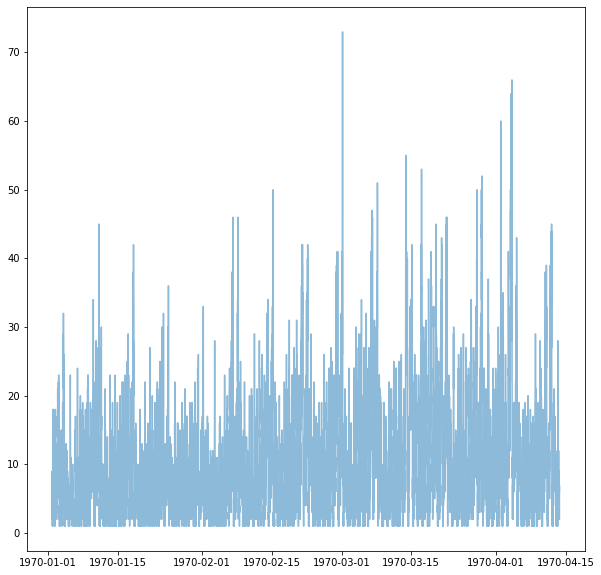

In [154]:
plt.figure(figsize=(10,10))
# plt.scatter(x_series,login_attempts.values,alpha=0.5)
plt.plot(login_attempts.index,login_attempts.values,alpha=0.5)
# plt.xlim(0,100)


This seems very dense and we are not able to draw any insights from this. Maybe we can be less granular and have data aggregaed at each hour

In [157]:
login_attempts_hour = df.groupby('new_date_hour')['minutes'].count()

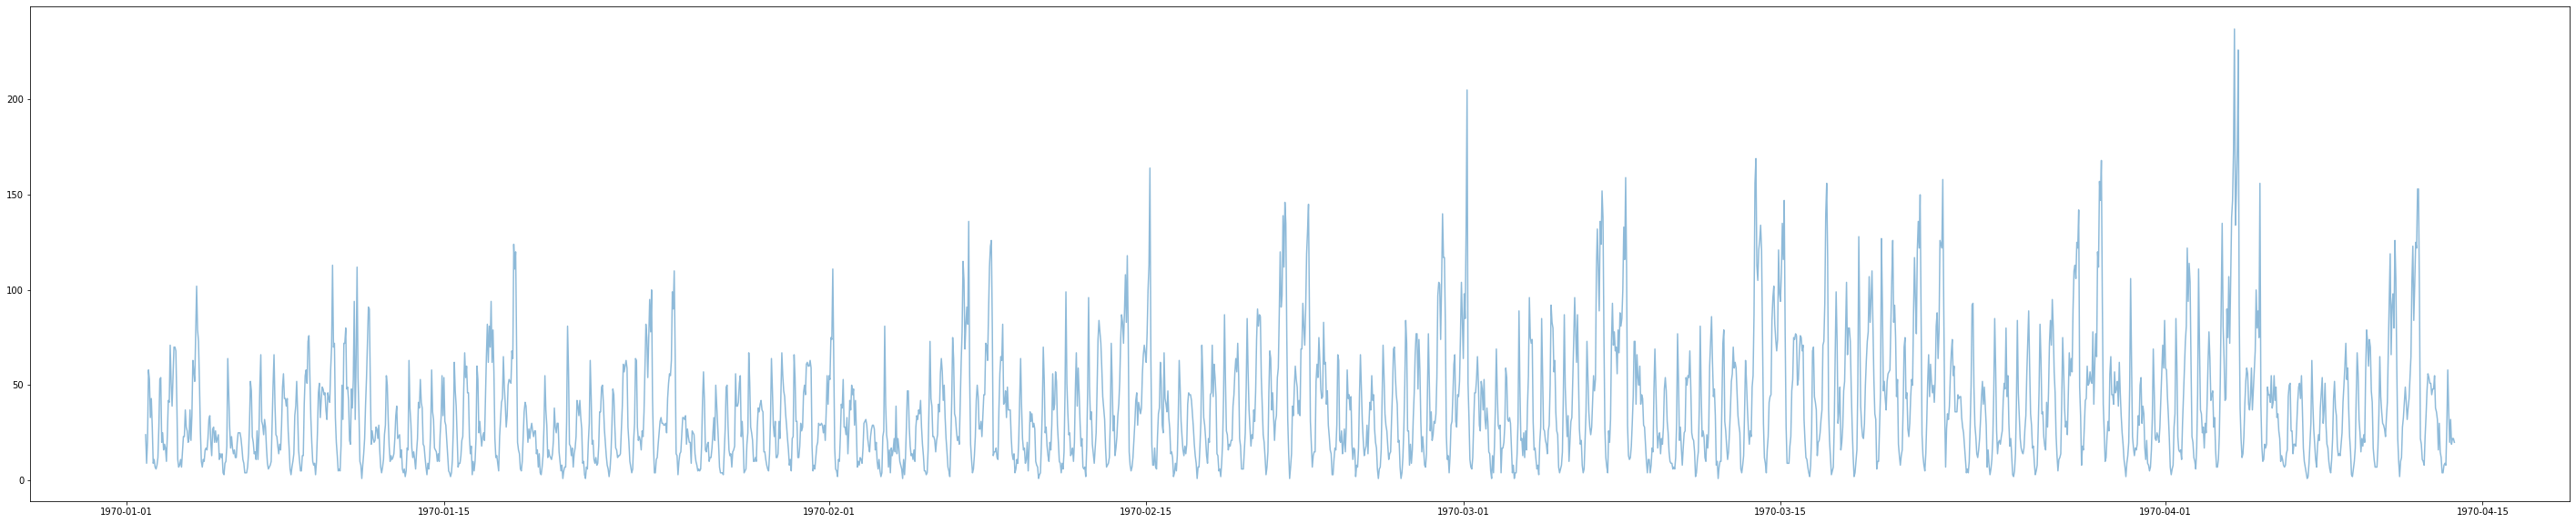

In [164]:
plt.figure(figsize=(50,10))
plt.plot(login_attempts_hour.index,login_attempts_hour.values,alpha=0.5)

This is a much better view, we do see cyclicity in the login patterns

In [167]:
df.head()

,login_time,year,month,day,hour,minute_actual,minutes,new_date,new_date_hour,date
0,1970-01-01 20:13:18,1970,1,1,20,13,0,1970-01-01 20:00:00,1970-01-01 20:00:00,1970-01-01
1,1970-01-01 20:16:10,1970,1,1,20,16,15,1970-01-01 20:15:00,1970-01-01 20:00:00,1970-01-01
2,1970-01-01 20:16:37,1970,1,1,20,16,15,1970-01-01 20:15:00,1970-01-01 20:00:00,1970-01-01
3,1970-01-01 20:16:36,1970,1,1,20,16,15,1970-01-01 20:15:00,1970-01-01 20:00:00,1970-01-01
4,1970-01-01 20:26:21,1970,1,1,20,26,15,1970-01-01 20:15:00,1970-01-01 20:00:00,1970-01-01


Another idea can be to visualize average number of login attempts by hours

In [166]:
df['date'] = pd.DatetimeIndex(df['login_time']).date

In [170]:
login_attempts_by_hr = df.groupby('hour').count()

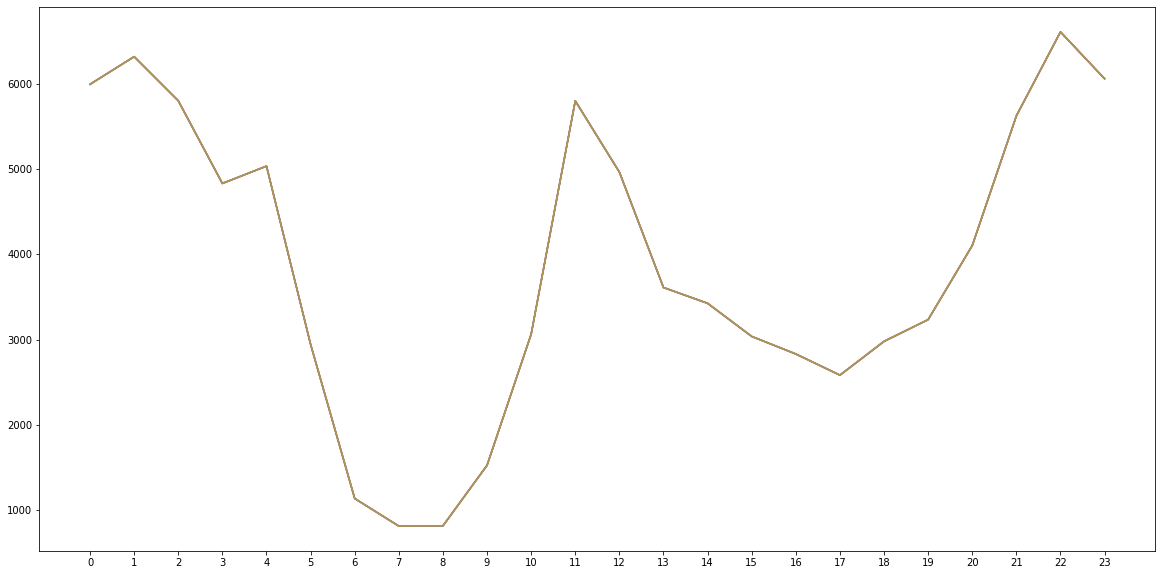

In [173]:
plt.figure(figsize=(20,10))
plt.plot(login_attempts_by_hr.index,login_attempts_by_hr.values,alpha=0.5);
plt.xticks(ticks=login_attempts_by_hr.index);

This is very helpful as we can see the cyclicity by the hour of the day. **Midnight and Noon time witness the hightest number of login attempts**

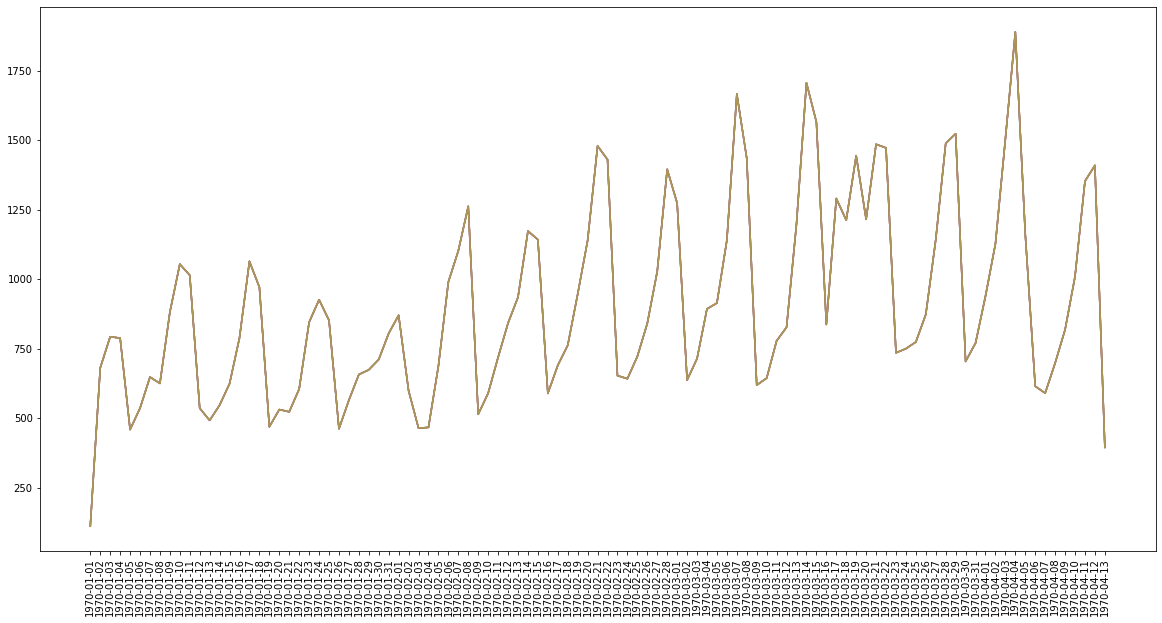

In [176]:
login_attempts_by_date = df.groupby('date').count()
plt.figure(figsize=(20,10))
plt.plot(login_attempts_by_date.index,login_attempts_by_date.values,alpha=0.5);
plt.xticks(ticks=login_attempts_by_date.index,rotation=90);

There is cyclicity even in the days, will be worth exploring the attemts by day of the week

In [179]:
df.head()

,login_time,year,month,day,hour,minute_actual,minutes,new_date,new_date_hour,date,dow
0,1970-01-01 20:13:18,1970,1,1,20,13,0,1970-01-01 20:00:00,1970-01-01 20:00:00,1970-01-01,3
1,1970-01-01 20:16:10,1970,1,1,20,16,15,1970-01-01 20:15:00,1970-01-01 20:00:00,1970-01-01,3
2,1970-01-01 20:16:37,1970,1,1,20,16,15,1970-01-01 20:15:00,1970-01-01 20:00:00,1970-01-01,3
3,1970-01-01 20:16:36,1970,1,1,20,16,15,1970-01-01 20:15:00,1970-01-01 20:00:00,1970-01-01,3
4,1970-01-01 20:26:21,1970,1,1,20,26,15,1970-01-01 20:15:00,1970-01-01 20:00:00,1970-01-01,3


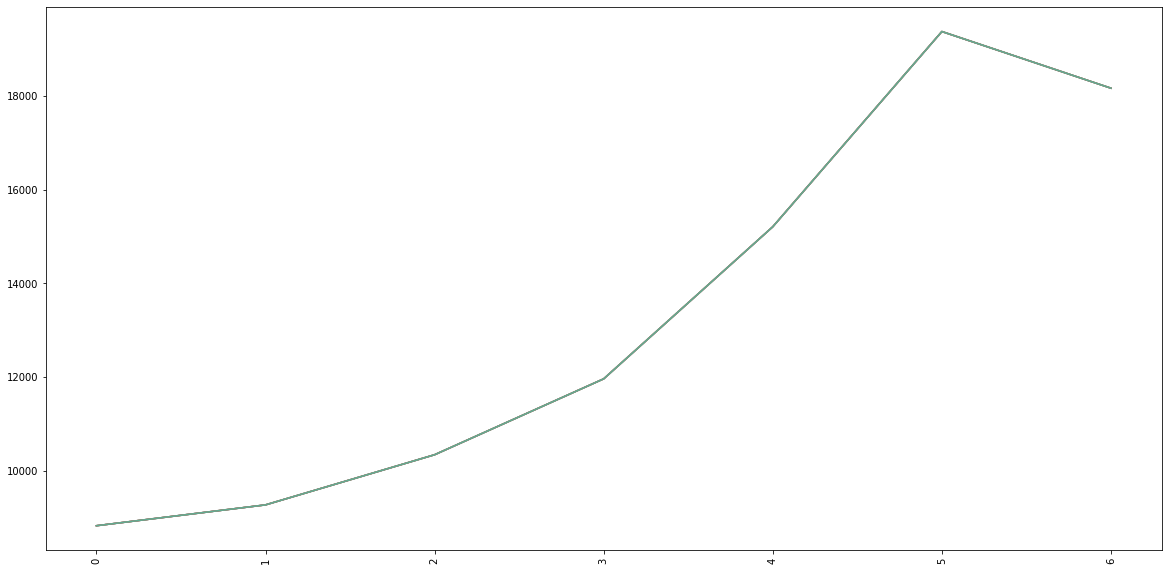

In [188]:
login_attempts_by_dow = df.groupby('dow').count()
plt.figure(figsize=(20,10))
plt.plot(login_attempts_by_dow.index,login_attempts_by_dow.values,alpha=0.5);
plt.xticks(ticks=login_attempts_by_dow.index,rotation=90);

So the max login attempts are on the weekends that too on saturday. As the week progresses, number of login attempts increase

# Part 3

In [237]:
df = pd.read_json("ultimate_data_challenge.json")

In [238]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [239]:
df.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [240]:
len(df)

50000

In [241]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [242]:
min(df['last_trip_date']), max(df['last_trip_date'])

('2014-01-01', '2014-07-01')

The data is a snapshot of first 6 months of 2014. So our dependent variable can be Actice/Inactive based on whther the user took thier last trip in June 2014

In [261]:
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

df['signup_month'] = df['signup_date'].dt.month

In [264]:
df['Active'] = (df['last_trip_date']>='2014-06-01').map({True:1, False:0})
df['ultimate_black_user'] = (df['ultimate_black_user']).map({True:1, False:0})

In [269]:
df.tail()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,Active,time_since_last_trip,signup_month
49995,King's Landing,0,2014-01-25,5.0,1.0,2014-06-05,iPhone,0.0,0,100.0,5.63,4.2,1,26,1
49996,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,iPhone,0.0,0,0.0,0.00,4.0,0,157,1
49997,Winterfell,0,2014-01-31,5.0,1.0,2014-05-22,Android,0.0,1,100.0,3.86,5.0,0,40,1
49998,Astapor,2,2014-01-14,3.0,1.0,2014-01-15,iPhone,0.0,0,100.0,4.58,3.5,0,167,1
49999,Astapor,0,2014-01-18,NaN,1.0,2014-04-20,Android,0.0,0,0.0,3.49,5.0,0,72,1


In [251]:
df['phone'].value_counts(normalize=True)

iPhone     0.697162
Android    0.302838
Name: phone, dtype: float64

In [252]:
df['phone'] = df['phone'].fillna('None')

In [253]:
df['city'].value_counts(normalize=True)*100

Winterfell        46.672
Astapor           33.068
King's Landing    20.260
Name: city, dtype: float64

In [267]:
df['time_since_last_trip'] = (datetime(2014,7,1) - pd.to_datetime(df['last_trip_date']))
df['time_since_last_trip'] = df['time_since_last_trip'].dt.days

In [268]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  int64         
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
 12  Active                  50000 non-null  int64 

In [235]:
df= pd.get_dummies(df)

In [272]:
df.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,Active,signup_month
0,King's Landing,4,4.7,1.10,iPhone,15.4,1,46.2,3.67,5.0,1,1
1,Astapor,0,5.0,1.00,Android,0.0,0,50.0,8.26,5.0,0,1
2,Astapor,3,4.3,1.00,iPhone,0.0,0,100.0,0.77,5.0,0,1
3,King's Landing,9,4.6,1.14,iPhone,20.0,1,80.0,2.36,4.9,1,1
4,Winterfell,14,4.4,1.19,Android,11.8,0,82.4,3.13,4.9,0,1


In [271]:
df.drop(['signup_date','last_trip_date','time_since_last_trip'],axis=1,inplace=True)

In [273]:
df = pd.get_dummies(df)

In [274]:
df.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,Active,signup_month,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_None,phone_iPhone
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,1,1,0,1,0,0,0,1
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,0,1,1,0,0,1,0,0
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,0,1,1,0,0,0,0,1
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,1,1,0,1,0,0,0,1
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,0,1,0,0,1,1,0,0


In [297]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Active'],axis=1),df['Active'], test_size=0.2,stratify=df['Active'])

In [298]:
imputer = KNNImputer()
imputer.fit(X_train)
X_train[:] = imputer.transform(X_train)
X_test[:] = imputer.transform(X_test)

In [299]:
X_train.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,signup_month,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_None,phone_iPhone
5519,3.0,5.0,1.3,50.0,1.0,66.7,2.22,4.9,1.0,0.0,1.0,0.0,0.0,0.0,1.0
21031,1.0,4.1,1.0,0.0,0.0,50.0,4.65,4.5,1.0,0.0,0.0,1.0,0.0,0.0,1.0
23858,0.0,4.9,1.0,0.0,0.0,100.0,7.74,5.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
48765,3.0,4.5,1.0,0.0,0.0,12.5,1.55,4.8,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3192,1.0,5.0,1.0,0.0,1.0,100.0,1.55,5.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [300]:
X_train.isnull().sum()

trips_in_first_30_days    0
avg_rating_of_driver      0
avg_surge                 0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
signup_month              0
city_Astapor              0
city_King's Landing       0
city_Winterfell           0
phone_Android             0
phone_None                0
phone_iPhone              0
dtype: int64

In [301]:
X_test.isnull().sum()

trips_in_first_30_days    0
avg_rating_of_driver      0
avg_surge                 0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
signup_month              0
city_Astapor              0
city_King's Landing       0
city_Winterfell           0
phone_Android             0
phone_None                0
phone_iPhone              0
dtype: int64

In [302]:
y_train.isnull().sum(), y_test.isnull().sum()

(0, 0)

In [303]:
len(X_test), len(y_test), len(X_train), len(y_train)

(10000, 10000, 40000, 40000)

In [304]:
#scaler
scaler = RobustScaler()
scaler.fit(X_train)
X_train[:] = scaler.transform(X_train)
X_test[:] = scaler.transform(X_test)

In [305]:
X_train.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,signup_month,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_None,phone_iPhone
5519,0.666667,0.333333,6.0,5.494505,1.0,0.000000,-0.367257,-0.333333,0.0,0.0,1.0,0.0,0.0,0.0,0.0
21031,0.000000,-1.166667,0.0,0.000000,0.0,-0.250375,0.170354,-1.666667,0.0,0.0,0.0,1.0,0.0,0.0,0.0
23858,-0.333333,0.166667,0.0,0.000000,0.0,0.499250,0.853982,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
48765,0.666667,-0.500000,0.0,0.000000,0.0,-0.812594,-0.515487,-0.666667,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3192,0.000000,0.333333,0.0,0.000000,1.0,0.499250,-0.515487,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [307]:
clf = XGBClassifier()
clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [308]:
pred = clf.predict(X_test)

In [313]:
confusion_matrix(y_true=y_test,y_pred=pred)

array([[5357,  882],
       [1274, 2487]], dtype=int64)

In [320]:
clf.feature_importances_

array([0.02771943, 0.01566657, 0.02076272, 0.06208768, 0.06759192,
       0.0409851 , 0.01464948, 0.13437441, 0.        , 0.05332577,
       0.327632  , 0.00911456, 0.09593171, 0.01177046, 0.11838814],
      dtype=float32)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 <a list of 15 Text xticklabel objects>)

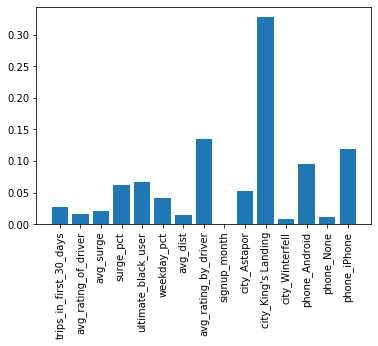

In [323]:
plt.bar(X_train.columns,clf.feature_importances_)
plt.xticks(rotation = 90)